# Домашняя работа №1

In [2]:
import cv2
import numpy as np
import math

from enum import Enum
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def plot_one_image(image: np.ndarray) -> None:
    """
    Отобразить изображение с помощью matplotlib.
    Вспомогательная функция.
    
    :param image: изображение для отображения
    :return: None
    """
    fig, axs = plt.subplots(1, 1, figsize=(8, 7))
    
    axs.imshow(image)
    axs.axis('off')
    plt.plot()

# Задача №1 - Лабиринт

Реализуйте алгоритм поиска выхода из лабиринта по растровому изобажению.
Вам нужно написать код, который будет находить путь (координаты пикселей) от заданного входа сверху до выхода снизу.

Отрисуйте получившийся маршрут на карте с помощью функции ```plot_maze_path(img, coords)``` или воспользуйтесь вам известным графическим инструментом.

__Input:__

Изображение лабиринта в кодировке $RGB$.

Все карты лежат на [яндекс-диске](https://yadi.sk/d/qEWVZk2picDdZw)

__Ouput:__

Массив координат пути через лабиринт в виде ```(np.array(x), np.array(y))```. 

Оценивается __каждое__ успешное решение лабиринта.
Пример решенной задачи.<img src="https://b.radikal.ru/b22/1906/56/df991f2221a7.png" width="300">

In [5]:
def is_wall(image: np.ndarray, pos):
    col_wall = image[0][0] 
    return all(image[pos[1]][pos[0]] == col_wall)

In [6]:
def find_start(image: np.ndarray):
    """
    Ищет вход (внизу)
    
    :param image: изображение лабиринта
    :return: точка старта
    """
    rows, cols, _ = image.shape
    l_x = 0;
    
    for x in range(cols):
        if not is_wall(image, [x, rows-1]):
            l_x = x-1
            break
    
    r_x = 0
    for x in range(l_x + 1, cols):
        if is_wall(image, [x, rows-1]):
            r_x = x - 1
            break
    return np.array([(l_x + r_x)//2, rows-1])
        

In [7]:
class MOVE(Enum):
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3

In [8]:
def direction_perpend(direction: MOVE):
    """
    Возвращает перпендикулярные направления
    """
    
    if direction == MOVE.UP or direction == MOVE.DOWN:
        return [MOVE.LEFT, MOVE.RIGHT]
    else:
        return [MOVE.UP, MOVE.DOWN]

In [9]:
def vect_move(direction: MOVE):
    """
    Возвращает вектор перемещения для MOVE
    """
    
    move = np.array([0,0])
    if direction == MOVE.UP:
        move[1] = -1
    elif direction == MOVE.DOWN:
        move[1] = 1
    elif direction == MOVE.LEFT:
        move[0] = -1
    else:
        move[0] = 1
    return move

In [10]:
def path_to_pos(start_pos, end_pos):
    """
    Прямой путь до точки (по направлению)

    :param start_pos: начало пути 
    :param end_pos: конец пути
    :return: путь
    """
    move = (end_pos - start_pos)//abs(end_pos - start_pos)
    pos = start_pos.copy()
    path = []
    while any(pos != end_pos):
        pos += move
        path.append(pos.copy())
    return path

## Сильное решение

In [11]:
def nearest_wall(image, pos, direction : MOVE):
    """
    Расстояние до ближайшей стены
    
    :param image: изображение лабиринта
    :param pos: точка, от которой ищется расстояние 
    :param direction: направление, по которому ищется ближайшая стена
    :return: расстояние
    """
    
    rows, cols, _ = image.shape
    new_pos = pos.copy()
    dist = 0
    move = vect_move(direction)

    # Идем пока не встретим стену или не выйдем за пределы изображения 
    while not is_wall(image, new_pos):
        new_pos += move
        dist += 1
        
        if new_pos[0] == -1 or new_pos[0] == cols:
            break
        if new_pos[1] == -1 or new_pos[1] == rows:
            break
    return dist   

In [12]:
def move_forward(image, start_pos, direction : MOVE):
    """
    Идет вперед пока по сторонам есть стенки
    
    :param image: изображение лабиринта
    :param direction: направление движения
    :param start_pos: начало движения 
    :return: (пройденный путь, есть ли путь дальше) (True - есть путь)
    """
    rows, cols, _ = image.shape
    path = []
    pos = start_pos.copy()
    perp_dir = direction_perpend(direction) # Перпендикулярные направления 
    move = vect_move(direction)
    
    # Рассчитываем расстояние до стенок
    walldist1 = nearest_wall(image, pos, perp_dir[0])
    walldist2 = nearest_wall(image, pos, perp_dir[1])
    
    # Идем
    while True:           
        pos += move
        
        # Проверка, что мы не вышли из лабиринта
        if pos[0] == -1 or pos[0] == cols:
            break
        if pos[1] == -1 or pos[1] == rows:
            break
    
        # Проверка на тупик
        if is_wall(image, pos):
            return (path, False)
          
        # Рассчитываем новые расстояния до стенок
        new_walldist1 = nearest_wall(image, pos, perp_dir[0])
        new_walldist2 = nearest_wall(image, pos, perp_dir[1])

        # Проверка, что не вышли на перекресток
        if abs(new_walldist1 - walldist1) > 1:
            break
        if abs(new_walldist2 - walldist2) > 1:
            break
        
        # Обновление расстояний до стенок и пути
        walldist1, walldist2 = new_walldist1, new_walldist2
        path.append(pos.copy())
        
    return (path, True)

In [40]:
def crossroad(image, start_pos, direction : MOVE):
    """
    Обрабатывает перекресток или поворот
    :param image: изображение лабиринта
    :param direction: Направление, где перекресток
    :param start_pos: точка входа
    :return: turple: (точка центра, список точек выхода, список направлений выхода)
    """
    pos = start_pos.copy() 
    
    # Расчет расстояния до стенок до входа на перекресток
    perp_dir = direction_perpend(direction)
    walldist1 = nearest_wall(image, pos, perp_dir[0])
    walldist2 = nearest_wall(image, pos, perp_dir[1])
    
    move = vect_move(direction)
    exit_pos = []
    exit_direction = []
    opposite_pos = start_pos.copy()
    
    # Проверям, что можно пойти вбок (в одну сторону)
    if abs(nearest_wall(image, pos+move, perp_dir[0]) - walldist1) > 1:
        near_exit = pos + move + walldist1*vect_move(perp_dir[0]) # ближайшая точка выхода 
        dist_far_exit = nearest_wall(image, near_exit, direction) # расстояние до конца перекрестка
        exit_pos.append(near_exit + dist_far_exit*move//2)        # рассчитываем середину выхода, то есть точку выхода
        exit_direction.append(perp_dir[0])                        # добавляем направление выхода
        
        # Расчет точки противоположной к точке входа (выход, если идти прямо)
        opposite_pos += (dist_far_exit+1)*vect_move(direction) 
        
    # Проверям, что можно пойти вбок (в другую сторону)
    if abs(nearest_wall(image, pos+move, perp_dir[1]) - walldist2) > 1:
        near_exit = pos + move + walldist2*vect_move(perp_dir[1]) # ближайшая точка выхода 
        dist_far_exit = nearest_wall(image, near_exit, direction) # расстояние до конца перекрестка
        exit_pos.append(near_exit + dist_far_exit*move//2)        # рассчитываем середину выхода, то есть точку выхода
        exit_direction.append(perp_dir[1])                        # добавляем направление выхода
        
        # Расчет точки противоположной к точке входа (если раньше не считали)
        if len(exit_pos) == 1:
            opposite_pos += (dist_far_exit+1)*vect_move(direction) 
    
    if not exit_pos:
        raise Exception("It isn't crossroad") 

    # Расчет центра перекрестка
    center = start_pos*abs(vect_move(perp_dir[0])) + exit_pos[0]*abs(vect_move(direction))
    
    # Проверяем, что можно пойти прямо
    if not is_wall(image, opposite_pos):
        exit_pos.append(opposite_pos)
        exit_direction.append(direction)
    
    return center, exit_pos, exit_direction 

In [41]:
def go(image: np.ndarray, path_before, start_direction : MOVE):
    """
    Функция путешествия, (конец cверху)
    
    :param image: изображение лабиринта
    :param path_before: путь до этого момента
    :param start_direction: начальное направление
    :return: (путь, дошел ли)
    """
    
    # Идем прямо, пока не будет перекрестка 
    path, not_dead_end = move_forward(image, path_before[-1], start_direction)
    path = path_before.copy() + path

    # Проверка, что не в тупике
    if not not_dead_end:
        return path, False
    
    # Проверка на победу
    if path[-1][1] == 0:
        return path, True
    
    # Смотрим куда можно пойти на перекрестке
    center_cross, exit_pos, exit_direction = crossroad(image, path[-1], start_direction)
    path += path_to_pos(path[-1], center_cross) # Добавляем путь до центра перекрестка
    
    # Поочереди рекурсивно идем в разные направления
    end_path = []
    for i, direction in enumerate(exit_direction):
        path_from_center = path.copy() + path_to_pos(path[-1], exit_pos[i]) # Добавляем путь до выхода из перекрестка
        end_path, win = go(image, path_from_center, direction)
        
        # Проверка на победу
        if win:
            return end_path, win
    return end_path, False
        
    

## Слабое решение

In [42]:
def easy_go(image: np.ndarray, path_before, start_direction : MOVE, walls_dist):
    """
    Функция путешествия, (конец cверху)
    
    :param image: изображение лабиринта
    :param path_before: путь до этого момента
    :param start_direction: начальное направление
    :param walls_dist: расстояние между стенками (белые клетки)
    :return: (путь, дошел ли)
    """ 
    path = path_before.copy()
    endpath = []
    move = vect_move(start_direction)
    path.append(path[-1] + move)
    
    # Победа
    if path[-1][1] == 0:
        return path, True
    
    # Проверяем, что можно пойти прямо и идем (если можно) 
    opposite_pos = path[-1] + (walls_dist+1)*move
    if not is_wall(image, opposite_pos):
        endpath = path_before.copy() + path_to_pos(path[-1], opposite_pos) # Добавляем путь до выхода
        endpath, win = easy_go(image, endpath, start_direction, walls_dist)
        if win:
            return endpath, True
        
    # Проверяем, что можно пойти вбок и идем (если можно)    
    perp_dirs = direction_perpend(start_direction)
    for perp_dir in perp_dirs:
        exit_pos = path[-1] + nearest_wall(image, path[-1], perp_dir)*(move + vect_move(perp_dir))
        if not is_wall(image, exit_pos):
            center_pos = path[-1]*abs(vect_move(perp_dir)) + exit_pos*abs(vect_move(start_direction))
            
            endpath = path.copy() + path_to_pos(path[-1], center_pos) # Добавляем путь к центру клетки
            endpath += path_to_pos(endpath[-1], exit_pos) # Добавляем путь к выходу из клетки
            endpath, win = easy_go(image, endpath, perp_dir, walls_dist) # Рекурсивно получаем путь
            
            # Если нашли победили
            if win:
                return endpath, True
    
    return endpath, False

In [43]:
def find_way_from_maze(image: np.ndarray, easy) -> tuple:
    """
    Найти путь через лабиринт.

    :param image: изображение лабиринта
    :param easy: слабый алгоритм (True), сильный алгоритм (False)
    :return: координаты пути из лабиринта в виде (x, y), где x и y - это массивы координат
    """
    rows, cols, _ = image.shape
    print('shape', image.shape)
    
    start_pos = find_start(image)
    
    if easy:
        walls_dist1 = nearest_wall(image, start_pos, MOVE.RIGHT)
        walls_dist2 = nearest_wall(image, start_pos, MOVE.LEFT)
        coords, win = easy_go(image, [start_pos], MOVE.UP, walls_dist1+walls_dist2-1)
        
    else:
        coords, win = go(image, [start_pos], MOVE.UP)

    x = [pos[0] for pos in coords]
    y = [pos[1] for pos in coords]

    return x,y


In [44]:
def plot_maze_path(image: np.ndarray, coords: tuple) -> np.ndarray:
    """
    Нарисовать путь через лабиринт на изображении. 
    Вспомогательная функция.
     
    :param image: изображение лабиринта
    :param coords: координаты пути через лабиринт типа (x, y) где x и y - массивы координат точек
    :return img_wpath: исходное изображение с отрисованными координатами 
    """
    if image.ndim != 3:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        
    img_wpath = image.copy()
    if coords:
        x, y = coords
        img_wpath[y, x, :] = [255, 0, 0]

    return img_wpath

Загрузим тестовое изображение и отобразим его.

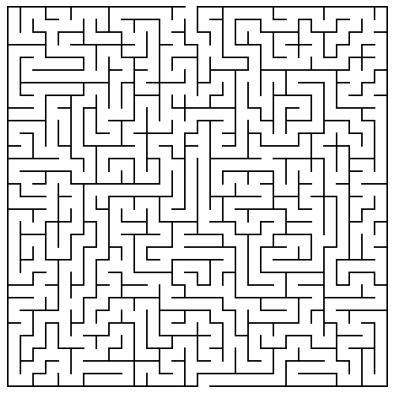

In [57]:
str = ['task_1/20 by 20 orthogonal maze.png', 
       'task_1/20 by 22 orthogonal maze.png',
       'task_1/25 by 22 orthogonal maze.png',
       'task_1/30 by 20 orthogonal maze.png',
       'task_1/30 by 30 orthogonal maze.png']
test_image = cv2.imread(str[4])  # загрузить тестовую картинку

plot_one_image(test_image)

Теперь ваша задача реализовать функцию ```plot_maze_path``` в ```task_1.py``` для того, чтобы найти координаты пути через лабиринт.

shape (482, 482, 3)


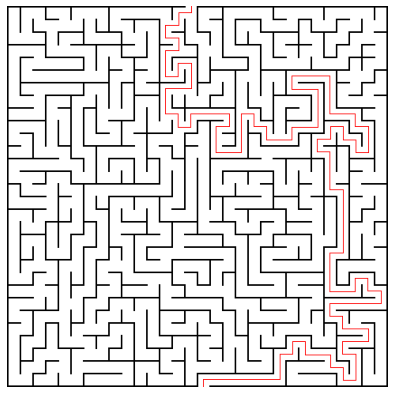

In [56]:
way_coords = find_way_from_maze(test_image, False)  # вычислить координаты пути через лабиринт

image_with_way = plot_maze_path(test_image, way_coords)

plot_one_image(image_with_way)

# Задача №2 - Пробки в городе

Требуется написать программу, которая на вход принимает картинку, на которой схематически изображена машинка на дороге с $N$ полосами и препятствия на полосах. Соответствующие объекты обозначены цветами, которые сохраняются на всех изображениях. 

Результатом работы программы является номер полосы, на которую нужно перестроиться или сообщение о том, что перестраиваться не нужно.

**Примечание: номер дороги считается слева направо, отсчет начинается с нуля.**

Примеры изображений:
<table><tr>
    <td> <img src="https://i.ibb.co/8z84sJG/image_00.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/Z6m4XFz/image_01.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

In [125]:
def comp_colors(col1, col2, dH=0.03):
    return abs(col1[0]-col2[0])/360 < dH

In [183]:
def borders_and_roads_colors(image: np.ndarray):
    """
    Цвета границ и дорог
    
    :param image: изображение
    :return: цвета границ и дорог)
    """
    rows, cols, _ = image.shape
    
    values, counts = np.unique(image[rows-1], return_counts=True, axis=0)
    road_col = values[counts.argmax()]
    values = np.delete(values, counts.argmax(), axis=0)

    bord_col = []
    for i,vcol in enumerate(values):
        if not vcol[0] == road_col[0]:
            bord_col.append(vcol)
    
    return (bord_col, road_col)

In [184]:
def is_bord(color, bord_colors):
    for bcol in bord_colors:
        if all(color == bcol):
            return True
    return False

In [240]:
def find_road_number(image_rgb: np.ndarray) -> int:
    """
    Найти номер дороги, на которой нет препятсвия в конце пути.

    :param image: исходное изображение
    :return: номер дороги, на котором нет препятсвия на дороге
    """
    image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)
    
    rows, cols, _ = image.shape
    road_number = None
    
    bord_colors, road_color = borders_and_roads_colors(image)
    
    num_col = 0
    num_road = 0
    
    colors = []  # там будут лежать другие цвета (не границы и дороги) встречающиеся на картинке
    roads = [] # там будут лежать списки дорог в которых встречаются цвета в cols
    skip_b = False
    while num_col < cols:
        old_num_col = num_col
        # Скипаем границы дороги
        while num_col < cols and is_bord(image[rows-1][num_col], bord_colors):
            num_col += 1
        
        # Если нашли не границу а плохую дорогу
        if num_col - old_num_col < 5:
            num_road -= 1
            skip_b = True
        else:
            skip_b = False

               
        old_num_col = num_col
        while num_col < cols and not is_bord(image[rows-1][num_col], bord_colors):
            col_colors = np.unique(image[:, num_col, :], axis=0)
              
            for color in col_colors:
                if comp_colors(color, road_color):
                    continue
                
                for ind, icolor in enumerate(colors):
                    if comp_colors(icolor, color):
                        if not (num_road in roads[ind]):
                            roads[ind].append(num_road)
                        break
                else:
                    colors.append(color)
                    roads.append([num_road])
            num_col += 1

        # Если нашли дорогу или перед этим это все-таки была граница)
        if num_col - old_num_col > 5 or skip_b:
            num_road += 1
        
    # Посмотрим какой цвет был на большем числе дорог это и будет цвет из препятствия
    ind = np.argmax([len(col_road) for col_road in roads])
    
    # посмотрим сколько дорог
    count_roads = len(roads[ind]) + 1
    
    road_number = list(set(range(count_roads)) - set(roads[ind]))[0]
    
    return road_number

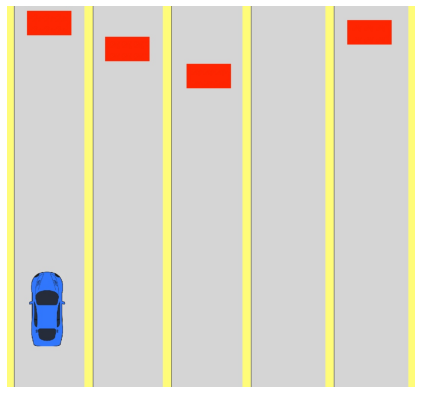

In [250]:
test_image = cv2.imread('task_2/image_01.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

plot_one_image(test_image)

In [251]:
road_number = find_road_number(test_image)

print(f'Нужно перестроиться на дорогу номер {road_number}')

Нужно перестроиться на дорогу номер 3


# Задача №3 - Аффинные преобразования

In [6]:
def vect(a):
    vect = np.array(a)
    vect.reshape(-1,1)
    return vect

In [39]:
def warpAffine(image, M):
    """
    Применить преобразование M и преобразовать размер изображения.

    :param image: изображение
    :param M: Матрица преобразования
    :return: преобразованное изображение
    """
    rows, cols, _ = image.shape
    
    xul,yul = M @ (0,0,1)
    xur,yur = M @ vect([cols-1, 0,1])
    xdl,ydl = M @ vect([0,rows-1,1])
    xdr,ydr = M @ vect([cols-1,rows-1,1])
    
    new_cols =  math.ceil(max(abs(xul-xdr), abs(xur-xdl)))
    new_rows =  math.ceil(max(abs(yul-ydr), abs(yur-ydl)))

    dx = -min(xul, xur, xdl, xdr)
    dy = -min(yul, yur, ydl, ydr)
    
    M[0][2] += dx
    M[1][2] += dy
    
    dst = cv2.warpAffine(image.copy(), M, (new_cols+1, new_rows+1))
    
    return dst

In [34]:
def apply_warpAffine(image, points1, points2) -> np.ndarray:
    """
    Применить афинное преобразование согласно переходу точек points1 -> points2 и
    преобразовать размер изображения.

    :param image:
    :param points1:
    :param points2:
    :return: преобразованное изображение
    """

    M = cv2.getAffineTransform(points1, points2)
    dst = warpAffine(image, M)
    return dst

In [35]:
def rotate(image, point: tuple, angle: float) -> np.ndarray:
    """
    Повернуть изображение по часовой стрелке на угол от 0 до 360 градусов и преобразовать размер изображения.

    :param image: исходное изображение
    :param point: значение точки (x, y), вокруг которой повернуть изображение
    :param angle: угол поворота
    :return: повернутное изображение
    """
    M = cv2.getRotationMatrix2D(point, angle, scale=1.0)
    dst = warpAffine(image, M)
    return dst

## Задача №3.1 - Поверни изображение

Реализуйте функцию, которая поворачивает изображение вокруг заданной точки на заданный угол ($0^\circ-360^\circ$) и преобразует размер изображения, чтобы оно не обрезалось после поворота.

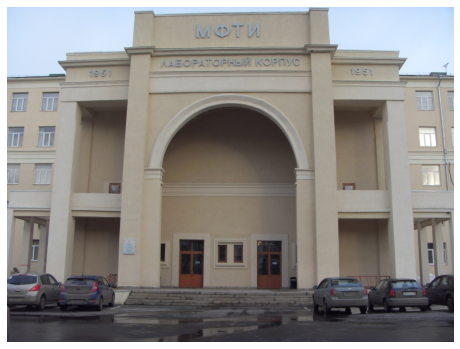

In [36]:
test_image = cv2.imread('task_3/lk.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
plot_one_image(test_image)

(1007, 1188, 3)


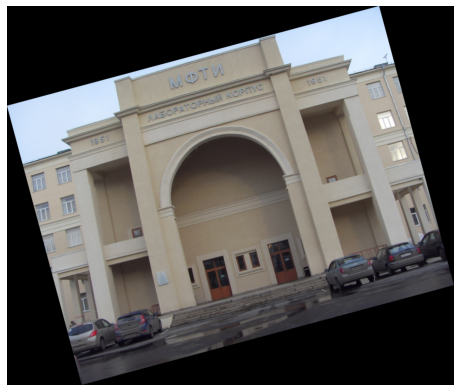

In [40]:
test_point = (200, 200)
test_angle = 15

transformed_image = rotate(test_image, test_point, test_angle)
print(transformed_image.shape)
plot_one_image(transformed_image)

Проверьте как это должно было получиться

(1007, 1188, 3)


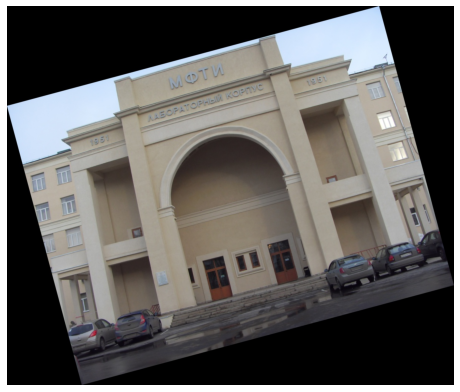

In [38]:
result_image = cv2.imread('task_3/lk_rotate.jpg')
result_image = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
print(result_image.shape)
plot_one_image(result_image)

## Задача №3.2 - Афинные преобразования

Реализуйте функцию, которая применяет афинное преобразование между заданными точками на исходном изображении и преобразует размер получившегося изображения, чтобы оно не обрезалось.

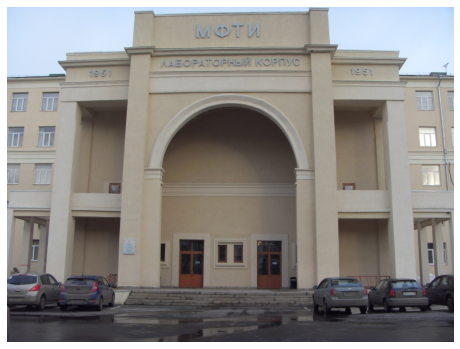

In [41]:
test_image = cv2.imread('task_3/lk.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
plot_one_image(test_image)

(1002, 294, 3)


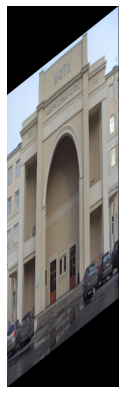

In [42]:
test_point_1 = np.float32([[50, 50], [400, 50], [50, 200]])
test_point_2 = np.float32([[100, 100], [200, 20], [100, 250]]) 

transformed_image = apply_warpAffine(test_image, test_point_1, test_point_2)
print(transformed_image.shape)
plot_one_image(transformed_image)

Проверьте как это должно было получиться

(1003, 293, 3)


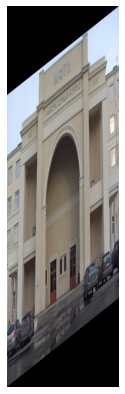

In [43]:
result_image = cv2.imread('task_3/lk_affine.jpg')
result_image = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
print(result_image.shape)
plot_one_image(result_image)